In [1]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config import config
from data_handling import unpickle
from image_feature_extraction import load_images, label_names_extraction, even_instances
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
path_features_network = config['paths']['network_representations']
path_restricted_dataset = config['paths']['restricted_dataset_path']
content_features_network = unpickle(path_features_network)
meta_classes = label_names_extraction(os.path.join(path_restricted_dataset, config['dataset_details']['class_info']))


#original with labels
train_data = content_features_network['train']
train_labels = content_features_network['train_labels']
test_data = content_features_network['test']
test_labels = content_features_network['test_labels']

In [3]:
#map train labels
mapped_train_labels = [meta_classes[x] for x in train_labels]
mapped_test_labels = [meta_classes[x] for x in test_labels]

### Visualization of CNN Codes
Here, I will visualize the features of CNN projected into two dimensions. I will use two dimensionality reduction techniques: PCA and TSNE (the first one, since it is standard and the second one, as it is also a common practice in CNNs, e.g. here: https://cs.stanford.edu/people/karpathy/cnnembed/).
<br>
Furthermore, I will explore how much variance is explained by the two dimensions nad I will try to reduce the data feature vector to not lose meaningful information, but also to speed up the computations in the final round. 

In [17]:
def reduce_dimensionality(input_data, n_dim, mode):
    if mode=='tsne':
        reducer = TSNE(n_components=n_dim, random_state=42, verbose=1)
    if mode=='pca':
        reducer = PCA(n_components=n_dim, random_state=42)
        x = reducer.fit(input_data)
        print("Explained variance ratio for PCA:", np.sum(x.explained_variance_ratio_))
    reduced_data = reducer.fit_transform(input_data)
    return reduced_data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data)


pca_data = reduce_dimensionality(scaled_data, 2, 'pca')


Explained variance ratio for PCA: 0.00568038908975


### PCA Visualization

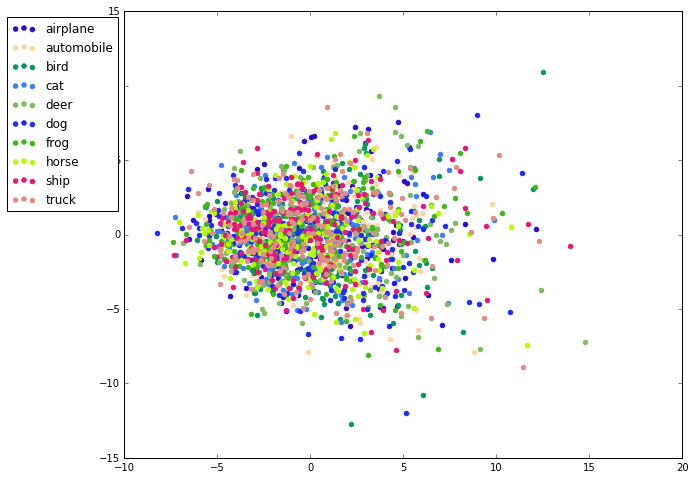

In [18]:
colors = {x: np.random.rand(3,1) for x in meta_classes.keys()}
plt.figure(figsize=(10,8))
for label in meta_classes.keys():
    ind = np.where(train_labels == label)[0]
    #take only n representatives of each class
    n=200
    ind = ind[:n]
    plt.scatter(pca_data[ind,0], pca_data[ind,1], label=meta_classes[label], color=colors[label])
plt.legend(meta_classes.values(), bbox_to_anchor=(0,1))
plt.show()

In [19]:
tsne_data = reduce_dimensionality(scaled_data, 2, 'tsne')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 3.120s...
[t-SNE] Computed neighbors for 5000 samples in 209.548s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 9.003777
[t-SNE] Computed conditional probabilities in 0.520s
[t-SNE] Iteration 50: error = 153.3554688, gradient norm = 0.2005444 (50 iterations in 17.882s)
[t-SNE] Iteration 100: error = 168.9474487, gradient norm = 0.3344832 (50 iterations in 16.904s)
[t-SNE] Iteration 150: error = 175.6884308, gradient norm = 0.1684337 (50 iterations in 17.966s)
[t-SNE] Iteration 200: error = 174.3011017, gradient norm = 0.2109957 (50 iterations in 18.231s)
[t-SNE] Iteration 250: error = 176.2619781, gradient norm 

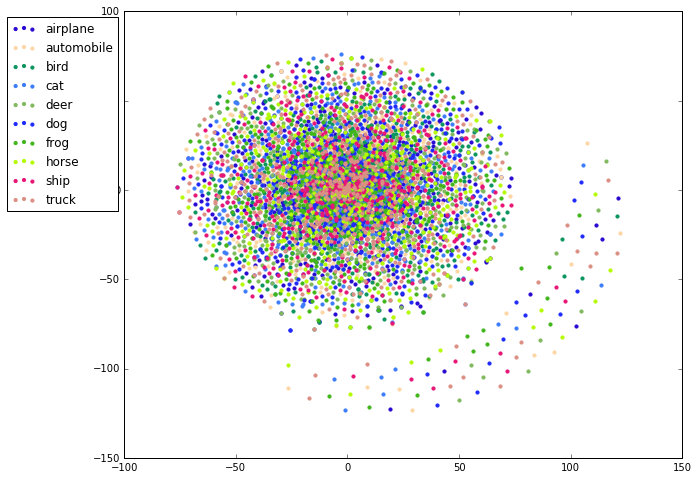

In [22]:
plt.figure(figsize=(10,8))
for label in meta_classes.keys():
    ind = np.where(train_labels == label)[0]
    #take only n representatives of each class
    n=200
    ind = ind[:n]
    plt.scatter(tsne_data[ind,0], tsne_data[ind,1], label=meta_classes[label], color=colors[label], s=10)
plt.legend(meta_classes.values(), bbox_to_anchor=(0,1))
plt.show()

### Train the SVM classifier on top of the CNN Codes
In this exercise, I will train the classifier on top of the retrieved CNN Codes. Since I have access to limited computing resources, I will use only linear kernel and check 3 values for gamma and C. Of course, the parameters could be further tuned.

In [23]:
###FINAL CLASSIFICATION
#1.5hours run
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import time

start = time.time()
parameters = {'gamma': [1e-1,1e-3, 1e-5],'C': [1, 10, 100]}
svm = SVC(kernel='linear')
gridsearch = GridSearchCV(svm, parameters, cv=5, n_jobs=3, scoring='accuracy', verbose=2)
gridsearch.fit(scaled_data, train_labels)
best_params = gridsearch.best_params_
prediction_score = gridsearch.best_score_
stop = time.time()
print("Execution finished in {}".format(stop-start))
print("Best parameters: {}".format(best_params))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=1, gamma=0.1 ..................................................
[CV] C=1, gamma=0.1 ..................................................
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total= 4.1min
[CV] C=1, gamma=0.1 ..................................................
[CV] ................................... C=1, gamma=0.1, total= 4.1min
[CV] ................................... C=1, gamma=0.1, total= 4.1min
[CV] C=1, gamma=0.1 ..................................................
[CV] C=1, gamma=0.001 ................................................
[CV] ................................... C=1, gamma=0.1, total= 4.7min
[CV] C=1, gamma=0.001 ................................................
[CV] ................................. C=1, gamma=0.001, total= 4.7min
[CV] ................................... C=1, gamma=0.1, total= 4.7min
[CV] C=1, gamma=0

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 76.3min


[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total= 4.3min
[CV] C=100, gamma=0.001 ..............................................
[CV] ............................... C=100, gamma=0.001, total= 4.3min
[CV] ............................... C=100, gamma=0.001, total= 4.3min
[CV] C=100, gamma=1e-05 ..............................................
[CV] C=100, gamma=1e-05 ..............................................
[CV] ............................... C=100, gamma=0.001, total= 4.8min
[CV] C=100, gamma=1e-05 ..............................................
[CV] ............................... C=100, gamma=1e-05, total= 4.8min
[CV] C=100, gamma=1e-05 ..............................................
[CV] ............................... C=100, gamma=1e-05, total= 4.8min
[CV] C=100, gamma=1e-05 ..............................................
[CV] ............................... C=100, gamma=1e-05, total= 5.4min
[CV] .

[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 98.2min finished


Execution finished in 6160.646961927414
Best parameters: {'gamma': 0.1, 'C': 1}


In [24]:
print("Best performance: {}".format(prediction_score))

Best performance: 0.094


In [25]:
#final prediction
scaled_test_data = scaler.transform(test_data)
c = best_params["C"]
gamma = best_params["gamma"]

final_SVM = SVC(kernel='linear', C=c, gamma=gamma)
finally_SVM.fit(scaled_data, train_labels)
predictions final_SVM.predict(scaled_test_data)

#printing results
print(classification_report(test_labels, predictions))

SyntaxError: invalid syntax (<ipython-input-25-5a90ce53924a>, line 8)